In [7]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Step 1: Create a sample dataset
data = {
    'Feature1': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'Feature2': [1.3, 1.9, 1, 2.1, 1.4, 1.7, 1.47, 1.67, 1, 2],
    'Target': [0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
}
df = pd.DataFrame(data)

# Step 2: Write dataset to an Excel file
excel_path = 'data.xlsx'
df.to_excel(excel_path, index=False)

# Step 3: Read the dataset back from the Excel file
df = pd.read_excel(excel_path)

# Step 4: Split data into features and target
X = df[['Feature1', 'Feature2']]
y = df['Target']

# Step 5: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 6: Initialize and train the decision tree classifier
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

# Step 7: Make predictions and evaluate
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)


Accuracy: 1.0


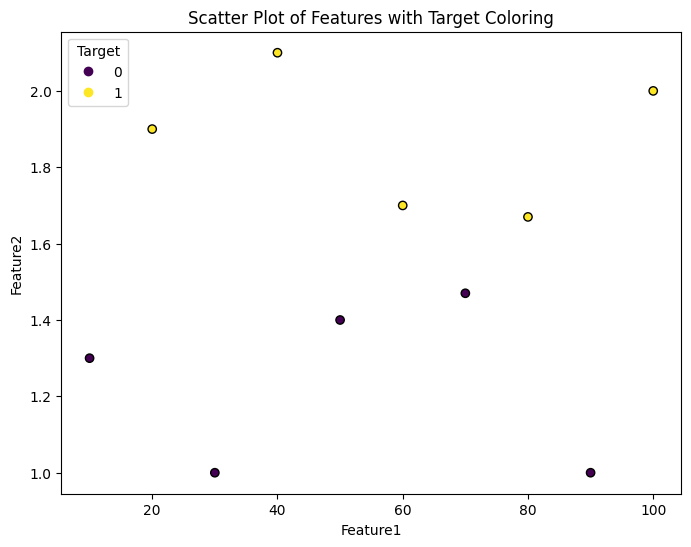

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the dataset (assuming it's already saved as 'data.xlsx' from the previous code)
df = pd.read_excel('data.xlsx')

# Plot the data with color based on the Target variable
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df['Feature1'], df['Feature2'], c=df['Target'], cmap='viridis', edgecolor='k')
plt.xlabel('Feature1')
plt.ylabel('Feature2')
plt.title('Scatter Plot of Features with Target Coloring')
plt.legend(*scatter.legend_elements(), title="Target")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx


class TreeNode:
    def __init__(self, left=None, right=None, value=None, threshold=None , feature_index=None, is_leaf=False):
        self.left = left
        self.right = right
        self.value = value
        self.threshold = threshold
        self.feature_index = feature_index
        self.is_leaf = is_leaf
class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
    
    def entropy(self, y):
        classes, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        entropy = sum(-p * np.log2(p) if p != 0 else 0 for p in probabilities)
        return entropy
    def gini(self, y):
        classes, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        gini = 1 - sum(p**2 for p in probabilities)
        return gini
    def split(self, X, y, feature_index, threshold):
        left_mask = X[:, feature_index] <=  threshold
        right_mask = X[:, feature_index] >threshold
        return X[left_mask], X[right_mask], y[left_mask], y[right_mask]
    def best_split(self, X, y):
        shape = X.shape
        if len(shape) == 1:
            shape = (shape[0], 1)
        
        n_samples, n_features = shape
        best_gini = float('inf')
        best_feature, best_threshold = None, None
        for feature_index in range(n_features):
            thresholds = np.unique(X[:, feature_index])
            thresholds_sorted = np.sort(thresholds)
            for i in range(len(thresholds_sorted)):
                if i > 0:
                    threshold = np.random.uniform(thresholds_sorted[i-1], thresholds_sorted[i])
                else:
                    threshold = thresholds_sorted[i]
                X_left, X_right, y_left, y_right = self.split(X, y, feature_index, threshold)
                if len(y_left) == 0 or len(y_right) == 0:
                    continue
                gini_left = self.gini(y_left)
                gini_right = self.gini(y_right)
                weighted_gini = (len(y_left) * gini_left + len(y_right) * gini_right) / n_samples
                if weighted_gini < best_gini:
                    best_gini = weighted_gini
                    best_feature = feature_index
                    best_threshold = threshold
        return best_feature, best_threshold
    def build_tree(self, X, y, depth):
        num_samples_per_class = [np.sum(y == i) for i in np.unique(y)]
        predicted_class = y[np.argmax(num_samples_per_class)]
        print(f"Depth: {depth}, Predicted class: {predicted_class}, Samples per class: {num_samples_per_class}")
        node = TreeNode(value=predicted_class)

        # Stop if max depth is reached or if all samples in the node are of the same class
        if depth == 0 or self.gini(y) == 0:
            node.is_leaf = True
            return node

        # Find the best split
        feature_index, threshold = self.best_split(X, y)

        if feature_index is None:
            node.is_leaf = True
            return node

        # Split the data
        
        X_left, X_right, y_left, y_right = self.split(X, y, feature_index, threshold)

        if len(y_left) == 0 or len(y_right) == 0:
            node.is_leaf = True
            return node

        node.feature_index = feature_index
        node.threshold = threshold
        node.is_leaf = False
        # Create the left and right child nodes
        node.left = self.build_tree(X_left, y_left, depth - 1)
        node.right = self.build_tree(X_right, y_right, depth - 1)
    
        return node

    
    def fit(self, X, y , max_depth=10):
        self.tree = self.build_tree(X, y, max_depth)
    def predict(self, X):
        return np.array([self._predict(self.tree, x) for x in X])
    def _predict(self, node, x):
        if node.is_leaf:
            return node.value
        if x[node.feature_index] <= node.threshold:
            return self._predict(node.left, x)
        else:
                return self._predict(node.right, x)
    def _draw_tree_graphically_with_networkx(self, node, G, pos, parent=None, depth=0, max_depth=10, x=0.0, y=0.0, x_offset=1.0):
        if node is None or depth > max_depth:
            return

        # Create unique labels for nodes
        if node.is_leaf:
            node_label = f"Leaf: {node.value}"
        else:
            node_label = f"X[{node.feature_index}] <= {node.threshold:.2f}"
        
        # Add the current node to the graph
        current_node_id = f"{depth}-{node_label}"  # Unique ID using depth and label
        G.add_node(current_node_id, label=node_label)

        # Set position for current node
        pos[current_node_id] = (x, y)

        # If there is a parent, add an edge from the parent to this node
        if parent is not None:
            G.add_edge(parent, current_node_id)

        # Recursively draw left and right subtrees
        if node.left is not None:
            # Move left
            self._draw_tree_graphically_with_networkx(node.left, G, pos, parent=current_node_id, depth=depth + 1, max_depth=max_depth, x=x - x_offset / (depth + 1), y=y - 1, x_offset=x_offset)
        
        if node.right is not None:
            # Move right
            self._draw_tree_graphically_with_networkx(node.right, G, pos, parent=current_node_id, depth=depth + 1, max_depth=max_depth, x=x + x_offset / (depth + 1), y=y - 1, x_offset=x_offset)

    def draw_tree_graphically(self, max_depth=10):
        G = nx.DiGraph()
        pos = {}
        self._draw_tree_graphically_with_networkx(self.tree, G, pos, max_depth=max_depth)

        # Extract labels
        labels = nx.get_node_attributes(G, 'label')
        
        # Draw the graph
        plt.figure(figsize=(12, 8))
        nx.draw(G, pos, with_labels=True, labels=labels, node_size=3000, node_color="skyblue", font_size=10, font_color="black", font_weight="bold", edge_color="gray")
        plt.title("Decision Tree Visualization")
        plt.show()


Depth: 10, Predicted class: 3, Samples per class: [6, 6, 2, 4, 2]
Depth: 9, Predicted class: 3, Samples per class: [6, 2]
Depth: 8, Predicted class: 3, Samples per class: [2]
Depth: 8, Predicted class: 0, Samples per class: [6]
Depth: 9, Predicted class: 1, Samples per class: [6, 4, 2]
Depth: 8, Predicted class: 1, Samples per class: [6]
Depth: 8, Predicted class: 4, Samples per class: [4, 2]
Depth: 7, Predicted class: 4, Samples per class: [4]
Depth: 7, Predicted class: 5, Samples per class: [2]
Tahminler: [3]
Karar Ağacı:
43.73055151920457
False
val 1


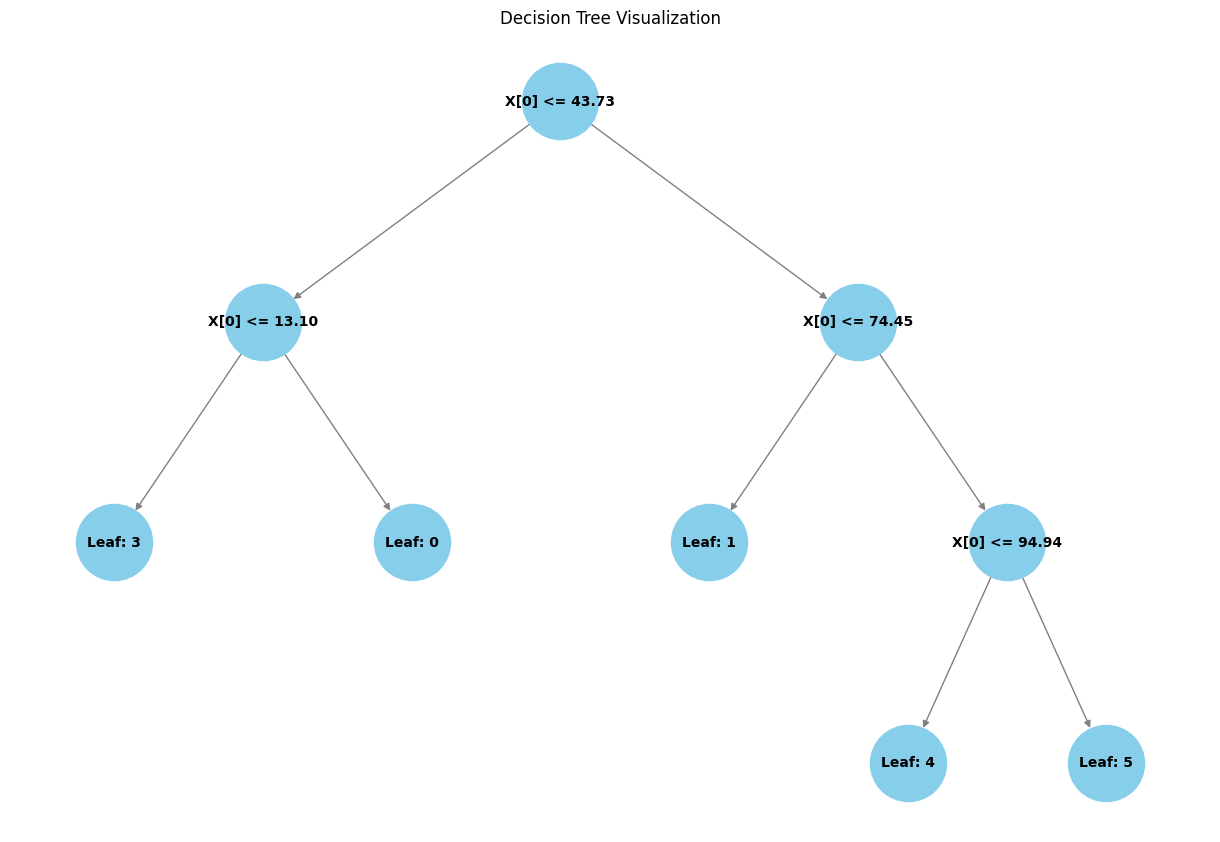

In [147]:
data = np.array([
    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100],
    [3, 3, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 5, 5]
])
X = np.array([data[0]]).T
y = np.array(data[1])
tree = DecisionTree(max_depth=5)
tree.fit(X, y)

# Tahmin edilen değerleri kontrol et
y_pred = tree.predict([[10]])
print("Tahminler:", y_pred)

# Karar ağacını çizdirme
print("Karar Ağacı:")
print(tree.tree.threshold)
print(tree.tree.is_leaf)
print("val "+str( tree.tree.right.value))

#print the tree graphically
tree.draw_tree_graphically()

Depth: 10, Predicted class: 1, Samples per class: [2, 5, 2, 1]
Depth: 9, Predicted class: 10, Samples per class: [2, 2, 1]
Depth: 8, Predicted class: 2, Samples per class: [2]
Depth: 8, Predicted class: 10, Samples per class: [2, 1]
Depth: 7, Predicted class: 10, Samples per class: [1]
Depth: 7, Predicted class: 0, Samples per class: [2]
Depth: 9, Predicted class: 1, Samples per class: [5]
Tahminler: [10]
Karar Ağacı:
1.6642792659672723
False
val 1


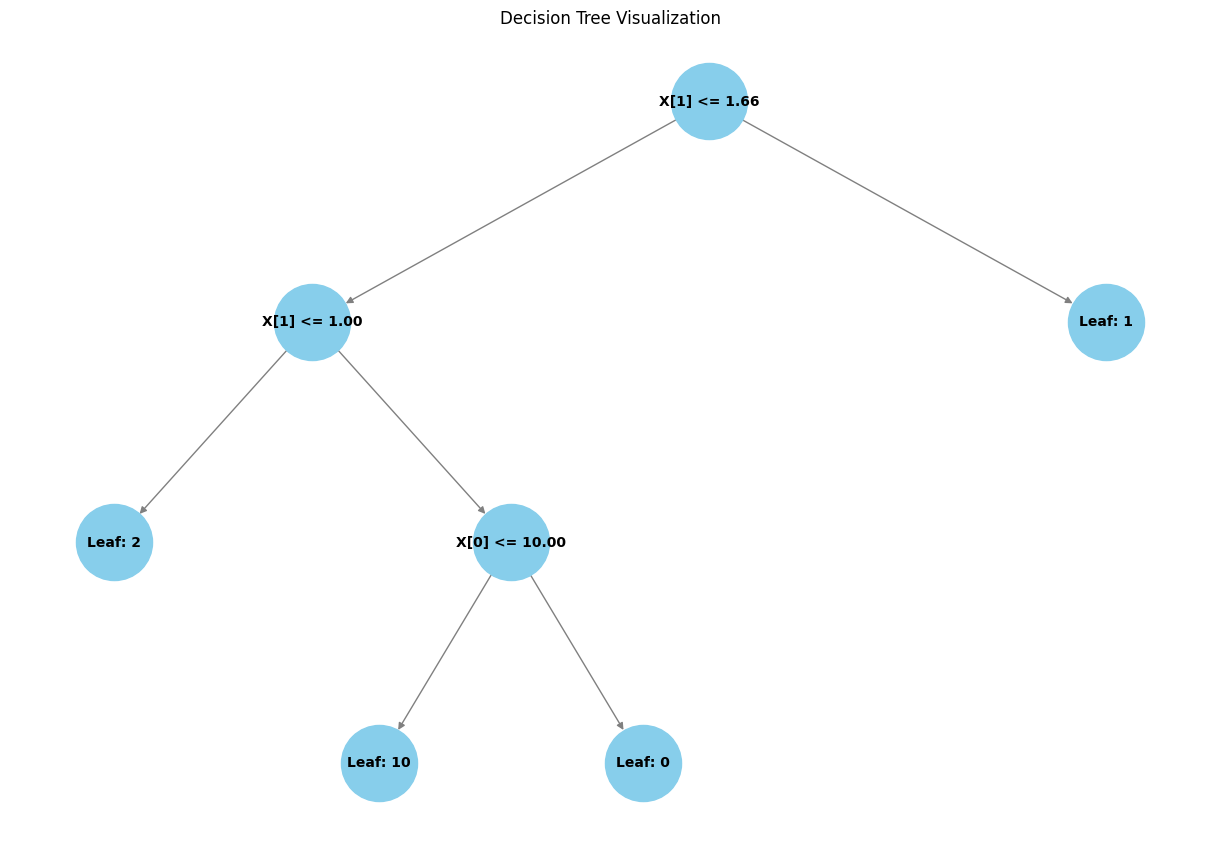

In [146]:
data = np.array([
    [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    [1.3, 1.9, 1, 2.1, 1.4, 1.7, 1.47, 1.67, 1, 2]
])
labels = np.array([10, 1, 2, 1, 0, 1, 0, 1, 2, 1])
X = np.array(data).T
y = np.array(labels)
tree = DecisionTree(max_depth=5)
tree.fit(X, y)

# Tahmin edilen değerleri kontrol et
y_pred = tree.predict([[10,1.3]])
print("Tahminler:", y_pred)

# Karar ağacını çizdirme
print("Karar Ağacı:")
print(tree.tree.threshold)
print(tree.tree.is_leaf)
print("val "+str( tree.tree.right.value))

#print the tree graphically
tree.draw_tree_graphically()


